In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow import keras
import time

In [2]:
from datetime import datetime
now=datetime.now()
date_time=now.strftime("%m-%d-%Y")

In [3]:
date_time

'01-22-2023'

In [4]:
print(tf.__version__)

2.6.2


In [5]:
BATCH_SIZE =1 #32   #1
IMG_SIZE = (160, 160)

In [6]:
# I left this because it sets up the directories automatically  
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)

In [7]:
# Different datasets to benchmark
#dataset_name='Animals_filtered'  # 50 animal dataset
dataset_name='cats_and_dogs_filtered'  #originalTF notebook dataset "full"
#dataset_name='fowl_data' # from https://learn.microsoft.com/en-us/azure/machine-learning/how-to-train-pytorch

PATH2 = os.path.join(os.path.dirname(path_to_zip),dataset_name )    
# also put in original
print(PATH2)

C:\Users\Tsvi\.keras\datasets\fowl_data


In [8]:
train_dir = os.path.join(PATH2, 'train')
validation_dir = os.path.join(PATH2, 'validation')

#print(third_animal_dataset_path,'\n',third_animal_train_dir,'\n',third_animal_validation_dir)
print(PATH2,'\n',train_dir,'\n',validation_dir)

C:\Users\Tsvi\.keras\datasets\fowl_data 
 C:\Users\Tsvi\.keras\datasets\fowl_data\train 
 C:\Users\Tsvi\.keras\datasets\fowl_data\validation


In [9]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                                         shuffle=True,
                                                                         batch_size=BATCH_SIZE,
                                                                         image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                              shuffle=True,
                                                                              batch_size=BATCH_SIZE,
                                                                              image_size=IMG_SIZE)

Found 230 files belonging to 2 classes.
Found 250 files belonging to 2 classes.


In [10]:
#print("original dataset class names:", train_dataset.class_names)
print("Dataset class names:", train_dataset.class_names)

Dataset class names: ['chickens', 'turkeys']


In [11]:
class_names = train_dataset.class_names
num_outputs=len(class_names)
print('number of classes and outputs:',num_outputs)

number of classes and outputs: 2


In [12]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [13]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 200
Number of test batches: 50


In [14]:
print('Number of training batches: %d' % tf.data.experimental.cardinality(train_dataset))

Number of training batches: 230


In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [16]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [17]:
#preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [18]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

In [19]:
#Training the model 10 epochs
initial_epochs = 1 #10  

In [20]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
#base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

In [21]:
#ResNEt=True #False
# MODEL = 'MobileNetV2'
MODEL = 'ResNet50'


In [22]:
if MODEL=='MobileNetV2':
    preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
    base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                                include_top=False,
                                                weights='imagenet')
elif MODEL=='ResNet50':
    preprocess_input = tf.keras.applications.resnet50.preprocess_input
    base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                                include_top=False,
                                                weights='imagenet')
else:
    error("Model Not supported")


In [23]:
base_model.trainable = False

In [24]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 166, 166, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 80, 80, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 80, 80, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [25]:
# the original adds 2d global_average_pooling2d layer to make the base layer ready for classification.  
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

In [26]:
# now I set up traditional learning and top layer, but I change from binary to multiclass so I must add softmax to top
final_output_layer=tf.keras.layers.Softmax()

In [27]:
# This is the multiclass equivalent to original transfer learning network  
prediction_layer4 = tf.keras.layers.Dense(num_outputs)  # change1 from original: I make num_outputs outputs
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = prediction_layer4(x)    # adds the 49 nodes
outputs = final_output_layer(x)  # change2: adds softmax
orig_TF_paradigm_model = tf.keras.Model(inputs, outputs)   # this is now the traditional leanring network

In [28]:
# Change 3:SparseCategoricalCrossentropy from BinaryCrossentropy because it is multiclass

base_learning_rate = 0.0001
orig_TF_paradigm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),  #loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'],
              run_eagerly=True,) # Now I compile it.  

In [29]:
orig_TF_paradigm_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 160, 160, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 160, 160, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 5, 5, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0     

In [30]:
# here I create the version of the base model that will feed inputs to OM layer and I call it model_with_av_layer
# it does not have anything after the global_average_layer
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
outputs = global_average_layer(x)
#outputs = prediction_layer(x)   # It is basically the same as the original notebook but no prediction layer
model_with_av_layer = tf.keras.Model(inputs, outputs) 


In [31]:
model_with_av_layer.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.__operators__.getitem_1 ( (None, 160, 160, 3)       0         
_________________________________________________________________
tf.nn.bias_add_1 (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 5, 5, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
Total params: 23,587,712
Trainable params: 0
Non-trainable params: 23,587,712
_______________________________________________

In [32]:
# Set up OM model that will take inputs from the 1280 outputs of model_with_av_layer

In [33]:
from OM_Model_learn import OM_CORE

In [34]:
num_inputs=model_with_av_layer.output.shape[1]  #1280

OMmodel = OM_CORE(num_inputs, num_outputs)

Version: OM core 0.27 minimzie from 5/12 3/21/2022 brought back stuff from 14 RFN conv


In [35]:
#OMmodel.update()   #in case it is run or tested un-initiated  
OMmodel.compile()

In [36]:
# this is an equivalent TF model that will recieve the OM weights
prediction_layer2 = tf.keras.layers.Dense(num_outputs)  # top nodes
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = prediction_layer2(x)  # nodes whose weights I will be changed by om
outputs = final_output_layer(x)  #softmax
tf_model_tobe_trained_by_OM = tf.keras.Model(inputs, outputs)


In [37]:
#it needs compile if I do validation but I never really do any learning so most of this doesnt really matter
base_learning_rate = 0.0001
tf_model_tobe_trained_by_OM.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),  #loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'],
              run_eagerly=True,) # Efi: needs to be added to prevent optimization

In [38]:
tf_model_tobe_trained_by_OM.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.__operators__.getitem_2 ( (None, 160, 160, 3)       0         
_________________________________________________________________
tf.nn.bias_add_2 (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 5, 5, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0   

In [39]:
# so I dont validate at every point for graphing (otherwise things take forever)
validate_points=np.concatenate([np.arange(30),np.arange(30,40,2),np.arange(40,60,3),np.arange(60,100,5),np.arange(100,300,7),np.arange(300,700,10),np.arange(700,1500,15),np.arange(1500,3000,20)])

In [40]:
len(validate_points)

248

In [41]:
# start re-run here 

In [42]:
# find the number of entries in thrid_animal_validation set: there doesnt seem to be an adequate internal function to do this!
# Im sure there is a better way but whatever
num_data_in_validation_dataset=0
for data, label in validation_dataset: #.as_numpy_iterator():
    num_data_in_validation_dataset=num_data_in_validation_dataset+len(data)
print(num_data_in_validation_dataset)

200


In [43]:
# setup validation manually so I dont have to go through base for every validation (saves time because validation is the same)
i=0
validation_labels=np.ones((1,num_data_in_validation_dataset))*50  #crazy initial values for debug
net_out_validation_for_OM=np.ones((num_data_in_validation_dataset,num_inputs))*50  

for data, label in validation_dataset: #.as_numpy_iterator():
    #print("Batch",i,"out of",num_data_in_validation_dataset,"size:",len(data),len(label))
    len_batch=len(label)
    #print(label)
    validation_labels[0,(BATCH_SIZE*i):(BATCH_SIZE*(i)+len_batch)]=label  # set up validation truth table
    temp=model_with_av_layer.predict(data)  #run bottom transfer layers pre-rfn
    net_out_validation_for_OM[BATCH_SIZE*i:(BATCH_SIZE*i+len_batch),:]=temp[0:len_batch,:]
    i=i+1
validation_labels=validation_labels.astype(int)


In [44]:
print(validation_labels[0,:])

[0 1 1 1 0 0 0 1 1 1 1 0 0 1 0 1 1 0 1 0 0 1 0 1 1 1 1 0 0 1 1 0 0 1 0 1 1
 0 1 0 0 0 0 0 1 0 0 0 1 1 1 0 0 0 0 0 1 0 0 1 1 0 1 1 1 1 0 0 1 1 1 1 0 1
 0 1 1 1 1 0 1 1 0 0 0 0 1 1 0 1 1 0 0 0 1 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1
 0 1 1 0 1 0 0 0 1 0 1 0 0 1 0 1 0 0 0 0 1 0 1 0 0 1 0 0 0 1 1 0 1 1 0 1 1
 1 0 0 1 0 0 1 0 1 1 1 1 0 0 1 1 0 0 0 0 0 0 0 1 1 1 1 1 0 0 1 0 1 1 1 1 1
 1 0 0 0 0 0 1 1 0 1 0 1 1 1 0]


In [45]:
# for batches
num_batches_in_train_dataset=len(train_dataset)              # number of batches in train_dataset
print("num of data of train batches in a single epoch",num_batches_in_train_dataset,"batch size =",BATCH_SIZE,"epochs=",initial_epochs)
OM_learn_Vacc=[] #0.5*np.ones(num_batches_in_train_dataset*initial_epochs)    #initializing as .5 just in case zeros gets through somehow  #np.zeros(num_batches_in_train_dataset)
tf_learn_Vacc=[] #0.5*np.ones(num_batches_in_train_dataset*initial_epochs)    #np.zeros(num_batches_in_train_dataset)

num of data of train batches in a single epoch 230 batch size = 1 epochs= 1


In [46]:
labels_presented=[]

In [47]:
tf_learn_Vacc

[]

In [48]:
# store baselines before learn
store_baselines_before_learning=False
if store_baselines_before_learning:
    loss_, accuracy_ = orig_TF_paradigm_model.evaluate(validation_dataset)
    print('validation of TF before train on new',accuracy_)
    tf_learn_Vacc.append(accuracy_) #store data

    OMmodel.test_data_score(net_out_validation_for_OM,validation_labels[0,:])  #validate for OM
    print('validation of OM on NEW data before train on new',OMmodel.last_score_accuracy/100)
    OM_learn_Vacc.append(OMmodel.last_score_accuracy/100) 
    
    # I want to add one more zero point and increase the index of everything by 1 to test before learning
    graph_points=list(validate_points.copy()+1)
    graph_points.insert(0,0)
else:
    graph_points=list(validate_points.copy())


In [49]:
initial_epochs=4

In [50]:
for j in range(initial_epochs):
    if j>0:  #update graph points if doing more than one epoch
        validate_points=np.concatenate([np.arange(0,3000,30)])
        graph_points[num_stored:]=[]
        graph_points=graph_points+list(validate_points.copy()+len(labels_presented)+1)   #need to figure out graphing stuff

    for i, data in train_dataset.enumerate():  #seems similar to fit 
        
        labels_presented.append(data[1])  # store record of labels presented
        
        #t = time.time()
        
        #the original learning        
        batch_logs = orig_TF_paradigm_model.train_step(data)
        
        #TF_time=time.time() - t

        
        #t = time.time()      # I include time to percolate data through base.  
        
        # prepare data to send out to OM.        
        net_out = model_with_av_layer.predict_on_batch(data[0])  # run through base layer to have data ready for OM
        
        # call to the API
        OMmodel.learn(net_out,data[1])  # needs data post base and label
        
        #OM_time=time.time() - t
        
        #print('Learning Time  OM:',np.round(OM_time,4),'  TF:',np.round(TF_time,4),'  TF/OM=',np.round(TF_time/OM_time,4),'X')
        
        # this would be equivalent to a callback from the API getting back the weights from the API
        # the TF structure recieves the weights that come back put into the trainable layer: OMmodel.ff_model
        tf_model_tobe_trained_by_OM.trainable_weights[0].assign(tf.Variable(np.float32(OMmodel.ff_model.T))) 
        # this is now the TF equivalent of OM learned net 
        
        #this is code to validate but it is repeated in the validated_points
        #loss0, accuracy0 = tf_model_tobe_trained_by_OM.evaluate(validation_dataset)  # it can be validated and run just like the original
        
        
        if i in validate_points:  # minimizing number of validations because it takes too long
        
            # validating TF learned top layer
            loss_, accuracy_ = orig_TF_paradigm_model.evaluate(validation_dataset)

            # validating directly with OM, This function is not needed in the API, just the tf_model_tobe_trained_by_OM code (a few down)
            OMmodel.test_data_score(net_out_validation_for_OM,validation_labels[0,:])  #,verbose=True) 
                
            # adding TF accuracies to the record
            tf_learn_Vacc.append(accuracy_)  
            
            # adding OM  accuracies to the records
            OM_learn_Vacc.append(OMmodel.last_score_accuracy/100) # using direct validation

            if False:  # extra sanity validation to show OMTF == OM core but extra tests take too much time if you are training the net
            
                # validating OM learned top layer but equivalent net to TF
                loss0, accuracy_OMTF = tf_model_tobe_trained_by_OM.evaluate(validation_dataset)  # it is validated and run just like the original TF
                #OM_learn_Vacc.append(accuracy_OMTF)

                print("Training: Batch {}, Epoch {}, {} entries accuracy of OM core {} OMTF {} (should be roughly equivalent to OM) and TF {} ".format(i,j, len(data[0]), OM_learn_Vacc[-1],accuracy_OMTF,accuracy_))
            
            else:
                print("Training: Batch {}, Epoch {}, {} entries accuracy of OM core {} and TF {} ".format(i,j, len(data[0]), np.round(OM_learn_Vacc[-1],4),np.round(accuracy_,4)))

        
    
    num_stored=len(OM_learn_Vacc)
    
    if False:  # epoch plot not implemented in this version
        OM_epoch_Vacc_old[j]=sum(OM_learn_Vacc_old[(j*num_batches_in_train_dataset):((j+1)*num_batches_in_train_dataset)])/num_batches_in_train_dataset
        tf_epoch_Vacc_old[j]=sum(tf_learn_Vacc_old[(j*num_batches_in_train_dataset):((j+1)*num_batches_in_train_dataset)])/num_batches_in_train_dataset
        print("Epoch {} summing {} batches to get epoch accuracy of OM on new {} old {} and TF on new {} old {} data".format(j,i,OM_epoch_Vacc[j],OM_epoch_Vacc_old[j],tf_learn_Vacc[j],tf_epoch_Vacc_old[j]))



 Learned [1] of label(s) [0] , previously [0. 0.] of each.
200/200 [==============================] - 21s 103ms/step - loss: 0.7687 - accuracy: 0.5200
 (Number correct, number incorrect, number of tests): ( 96 104 200 ) %Correct:  48.0 %
False Positives by label: [104.   0.]
False Negatives by label: [  0. 104.]
See   .last_score_accuracy for % accuracy value
Training: Batch 0, Epoch 0, 1 entries accuracy of OM core 0.48 and TF 0.52 
 Learned [1] of label(s) [1] , previously [1. 0.] of each.
200/200 [==============================] - 20s 98ms/step - loss: 0.7698 - accuracy: 0.5200
 (Number correct, number incorrect, number of tests): ( 127 73 200 ) %Correct:  63.5 %
False Positives by label: [13. 60.]
False Negatives by label: [60. 13.]
See   .last_score_accuracy for % accuracy value
Training: Batch 1, Epoch 0, 1 entries accuracy of OM core 0.635 and TF 0.52 
 Learned [1] of label(s) [1] , previously [1. 1.] of each.
200/200 [==============================] - 20s 99ms/step - loss: 0.77

 Learned [1] of label(s) [1] , previously [ 8. 11.] of each.
200/200 [==============================] - 19s 97ms/step - loss: 0.7770 - accuracy: 0.5100
 (Number correct, number incorrect, number of tests): ( 168 32 200 ) %Correct:  84.0 %
False Positives by label: [13. 19.]
False Negatives by label: [19. 13.]
See   .last_score_accuracy for % accuracy value
Training: Batch 19, Epoch 0, 1 entries accuracy of OM core 0.84 and TF 0.51 
 Learned [1] of label(s) [1] , previously [ 8. 12.] of each.
200/200 [==============================] - 23s 114ms/step - loss: 0.7716 - accuracy: 0.5200
 (Number correct, number incorrect, number of tests): ( 167 33 200 ) %Correct:  83.5 %
False Positives by label: [15. 18.]
False Negatives by label: [18. 15.]
See   .last_score_accuracy for % accuracy value
Training: Batch 20, Epoch 0, 1 entries accuracy of OM core 0.835 and TF 0.52 
 Learned [1] of label(s) [1] , previously [ 8. 13.] of each.
200/200 [==============================] - 20s 100ms/step - loss:

 Learned [1] of label(s) [0] , previously [15. 29.] of each.
 Learned [1] of label(s) [1] , previously [16. 29.] of each.
 Learned [1] of label(s) [1] , previously [16. 30.] of each.
200/200 [==============================] - 20s 101ms/step - loss: 0.7641 - accuracy: 0.5250
 (Number correct, number incorrect, number of tests): ( 169 31 200 ) %Correct:  84.5 %
False Positives by label: [14. 17.]
False Negatives by label: [17. 14.]
See   .last_score_accuracy for % accuracy value
Training: Batch 46, Epoch 0, 1 entries accuracy of OM core 0.845 and TF 0.525 
 Learned [1] of label(s) [1] , previously [16. 31.] of each.
 Learned [1] of label(s) [0] , previously [16. 32.] of each.
 Learned [1] of label(s) [0] , previously [17. 32.] of each.
200/200 [==============================] - 20s 98ms/step - loss: 0.7593 - accuracy: 0.5300
 (Number correct, number incorrect, number of tests): ( 169 31 200 ) %Correct:  84.5 %
False Positives by label: [15. 16.]
False Negatives by label: [16. 15.]
See   

 Learned [1] of label(s) [1] , previously [40. 58.] of each.
 Learned [1] of label(s) [0] , previously [40. 59.] of each.
 Learned [1] of label(s) [1] , previously [41. 59.] of each.
200/200 [==============================] - 20s 99ms/step - loss: 0.7161 - accuracy: 0.5500
 (Number correct, number incorrect, number of tests): ( 176 24 200 ) %Correct:  88.0 %
False Positives by label: [ 8. 16.]
False Negatives by label: [16.  8.]
See   .last_score_accuracy for % accuracy value
Training: Batch 100, Epoch 0, 1 entries accuracy of OM core 0.88 and TF 0.55 
 Learned [1] of label(s) [1] , previously [41. 60.] of each.
 Learned [1] of label(s) [1] , previously [41. 61.] of each.
 Learned [1] of label(s) [0] , previously [41. 62.] of each.
 Learned [1] of label(s) [0] , previously [42. 62.] of each.
 Learned [1] of label(s) [0] , previously [43. 62.] of each.
 Learned [1] of label(s) [0] , previously [44. 62.] of each.
 Learned [1] of label(s) [1] , previously [45. 62.] of each.
200/200 [=====

200/200 [==============================] - 20s 98ms/step - loss: 0.6520 - accuracy: 0.6350
 (Number correct, number incorrect, number of tests): ( 178 22 200 ) %Correct:  89.0 %
False Positives by label: [ 8. 14.]
False Negatives by label: [14.  8.]
See   .last_score_accuracy for % accuracy value
Training: Batch 170, Epoch 0, 1 entries accuracy of OM core 0.89 and TF 0.635 
 Learned [1] of label(s) [0] , previously [76. 95.] of each.
 Learned [1] of label(s) [1] , previously [77. 95.] of each.
 Learned [1] of label(s) [0] , previously [77. 96.] of each.
 Learned [1] of label(s) [0] , previously [78. 96.] of each.
 Learned [1] of label(s) [0] , previously [79. 96.] of each.
 Learned [1] of label(s) [1] , previously [80. 96.] of each.
 Learned [1] of label(s) [0] , previously [80. 97.] of each.
200/200 [==============================] - 20s 101ms/step - loss: 0.6513 - accuracy: 0.6200
 (Number correct, number incorrect, number of tests): ( 179 21 200 ) %Correct:  89.5 %
False Positives b

In [51]:
OM_learn_Vacc'

[0.48,
 0.635,
 0.53,
 0.52,
 0.52,
 0.52,
 0.57,
 0.7,
 0.68,
 0.635,
 0.715,
 0.715,
 0.67,
 0.74,
 0.81,
 0.815,
 0.805,
 0.825,
 0.845,
 0.84,
 0.835,
 0.835,
 0.85,
 0.85,
 0.845,
 0.865,
 0.86,
 0.86,
 0.865,
 0.875,
 0.865,
 0.87,
 0.865,
 0.85,
 0.855,
 0.85,
 0.845,
 0.845,
 0.845,
 0.855,
 0.85,
 0.855,
 0.86,
 0.855,
 0.87,
 0.86,
 0.86,
 0.87,
 0.87,
 0.885,
 0.88,
 0.89,
 0.89,
 0.88,
 0.87,
 0.895,
 0.895,
 0.9,
 0.895,
 0.895,
 0.89,
 0.895,
 0.9,
 0.895,
 0.895,
 0.895,
 0.895,
 0.895,
 0.895]

In [52]:
# indicate when all animals are presented at least once
all_presented=1
while len(np.unique(labels_presented[0:all_presented])) != len(np.unique(labels_presented)):
    all_presented=all_presented+1
all_presented=np.where(np.array(graph_points) >= all_presented)[0][0]   #first index where all presented
print('first validation run after all animals were presented:',all_presented,'\nwhich begins with training instance',graph_points[all_presented])

first validation run after all animals were presented: 2 
which begins with training instance 2


In [53]:
grange=int(graph_points[num_stored]*.02)     #90  #31 #90 #121  # choosing a nice zoom range
if grange==0:
    grange=num_stored
maxpoint=max(graph_points[0:grange])
print(maxpoint)

3


In [54]:
grange

4

first 4 plots


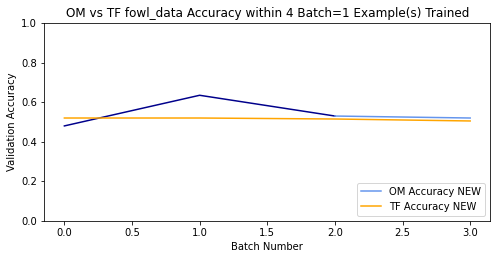

Labels   [[0 1 1 1]]


In [55]:
# zoomed figure
print('first',graph_points[grange],'plots')

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)

plt.plot(graph_points[0:(all_presented+1)],OM_learn_Vacc[0:(all_presented+1)],color='darkblue')
plt.plot(graph_points[all_presented:grange],OM_learn_Vacc[all_presented:grange],color='cornflowerblue', label='OM Accuracy NEW')
plt.plot(graph_points[0:grange],tf_learn_Vacc[0:grange],color='orange', label='TF Accuracy NEW')



plt.legend(loc='lower right')
plt.ylabel('Validation Accuracy')
#plt.ylim([min(plt.ylim()),1])
plt.ylim([0.0,1.0])
plt.title("OM vs TF {} Accuracy within {} Batch={} Example(s) Trained".format(dataset_name,graph_points[grange],BATCH_SIZE))

plt.xlabel('Batch Number')
plt.show()
print('Labels  ',np.array(labels_presented)[0:grange].T)

In [56]:
grange=num_stored

In [57]:
print(max(graph_points),num_stored,graph_points[num_stored])

2980 69 233


first 233 plots


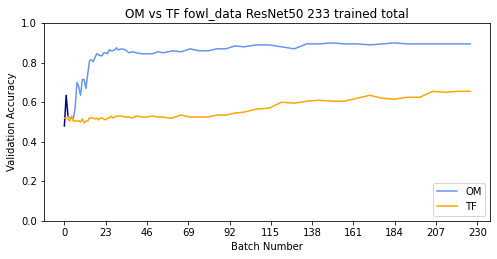

Labels   [[0 1 1 1 1 1 0 0 1 1 0 1 1 0 0 1 1 0 0 1 1 1 1 1 1 0 0 1 1 0 1 1 0 1 0 1
  1 1 1 0 0 1 1 1 0 1 1 1 0 0 1 1 1 1 0 0 1 1 0 1 1 0 0 0 1 0 0 0 1]]


In [58]:
#unzoomed figure
print('first',graph_points[grange],'plots')

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
#plt.plot(graph_points[0:grange],third_animal_OM_learn_Vacc[0:grange], label='OM Accuracy NEW')
#plt.plot(graph_points[0:grange],third_animal_tf_learn_Vacc[0:grange], label='TF Accuracy NEW')

plt.plot(graph_points[0:(all_presented+1)],OM_learn_Vacc[0:(all_presented+1)],color='darkblue')
plt.plot(graph_points[all_presented:grange],OM_learn_Vacc[all_presented:grange],color='cornflowerblue', label='OM')
plt.plot(graph_points[0:grange],tf_learn_Vacc[0:grange],color='orange', label='TF')



plt.legend(loc='lower right')
plt.ylabel('Validation Accuracy')
#plt.ylim([min(plt.ylim()),1])
plt.ylim([0.0,1.0])
#if ResNEt:
#    fname="ResNet50"
#else:
#    fname="MobileNetV2"

plt.title("OM vs TF {} {} {} trained total".format(dataset_name,MODEL,graph_points[grange]))
plt.xticks(np.arange(0,graph_points[num_stored]+1,int(graph_points[num_stored]/10)))  # Set label locations.



plt.xlabel('Batch Number')
plt.show()
print('Labels  ',np.array(labels_presented)[0:grange].T)

In [59]:
OMmodel.rfn_weights.shape

(2, 2048)

In [60]:
#if ResNEt:
#    fname="ResNet50_"+dataset_name
#else:
#    fname="MobileNetV2_"+dataset_name

fname=MODEL+"_"+dataset_name
np.save(fname, OMmodel.ff_model)


In [61]:
orig_TF_paradigm_model.trainable_weights[0]

<tf.Variable 'dense/kernel:0' shape=(2048, 2) dtype=float32, numpy=
array([[ 0.04259898,  0.01962377],
       [ 0.0391567 , -0.05411763],
       [ 0.000989  ,  0.00372347],
       ...,
       [-0.0380608 ,  0.03631028],
       [-0.0396256 , -0.03165526],
       [-0.0215494 , -0.04053424]], dtype=float32)>

In [62]:
np.save(fname+'_TF',orig_TF_paradigm_model.trainable_weights[0])

In [63]:
fname

'ResNet50_fowl_data'

In [64]:
np.load(fname+'.npy').T

array([[ 4.47937422e-05,  2.76027945e-04],
       [ 1.96002288e-04,  2.27025607e-04],
       [ 7.43085384e-04, -3.08711919e-04],
       ...,
       [-1.07867107e-04,  3.31566142e-04],
       [ 1.43827987e-03, -8.69746551e-04],
       [-6.13972461e-05,  2.62284258e-04]])

In [65]:
stop-here

NameError: name 'stop' is not defined

In [ ]:
b=np.where(OMmodel.rfn_weights[0]==OMmodel.rfn_weights[1])

In [ ]:
len(b[0])

In [ ]:
from math import isclose
num_feat=len(OMmodel.rfn_weights[0,:])

In [ ]:
close_array=np.zeros(num_feat)
for k in range(num_feat):
    close_array[k]=isclose(OMmodel.rfn_weights[0,k],OMmodel.rfn_weights[1,k], abs_tol=1e-3)
np.sum(close_array)

In [ ]:
np.linalg.cond(OMmodel.rfn_weights)

In [ ]:
base_model.layers[1].get_weights()[0].shape

In [ ]:
# save accuracies and TF model for future analysis if needed
np.save("TF trained using {} batch={} on {}.npy".format(dataset_name,BATCH_SIZE,date_time),tf_learn_Vacc)
np.save("OM trained using {} batch={} on {}.npy".format(dataset_name,BATCH_SIZE,date_time),OM_learn_Vacc)
orig_TF_paradigm_model.save("orig_TF_paradigm_model trained using {} on {}".format(dataset_name,date_time))  # automate date


In [ ]:
#import logging
#import json
#from keras_sequential_ascii import sequential_model_to_ascii_printout
#import scipy.linalg as scialg
#import sympy as sy


In [ ]:
#pathfilename = 'wsfile/' + 'explain_for_DeGirum.' + 'lg'  # temp, have much betterin in file omnnbu_no_json
#logging.info('pathfilename <> ' + pathfilename)


In [ ]:
#explain_ff_components(np.array([]),base_model)  

In [ ]:
#pathfilename

In [ ]:
def sanity_report_brief(W,verbose=False):
    #print("Report on filters without changing anything.")
    #logging.info("Report on filters without changing anything.".format())

    Wsum_min=1e-4  #cancels flter
    Wsingle_branch_min=1e-6  #cancels branch
    

    h_filter, w_filter, numim,  n_filters = W.shape  #n_filters is the same as outputs, prints one way shapes another WTF
    #numim, n_filters, h_filter, w_filter = W.shape  #wtf figuring order by trial and error
    #num_inputs=layer_weights[0].shape[2]  #I believe if I recall correctly... previously: prev.shape[3]  #inputs
    #num_outputs=layer_weights[0].shape[3]   #outs
    #filter_h=layer_weights[0].shape[0]   #
    #filter_w=layer_weights[0].shape[1]   #
    
    #print('hilter size:',h_filter*w_filter,"W shape",W.shape,'WTF why switch n_filters:',n_filters,' numim:',numim)
    


    #BWW=np.zeros_like(W)  #dont need for report
    status=np.ones((n_filters,numim))*h_filter*w_filter   #ishape+2*pad,ishape+2*pad))
    remove_input=0
    remove_output=0
    cancel=0
    modify=0
    for n in range(n_filters):
        for nxt in range(numim):
            abs=np.abs(W[:,:,nxt,n])
            #abs=np.abs(W[n,nxt,:,:]) also need modify
            if np.sum(abs)<1e-4: 
                #print("total sum of filter ",n,nxt,"is less than 1e-4. Prone to error. Zeroing filter")
                #W[n,nxt,:,:]=0
                #BWW[n,nxt,:,:]=0
                status[n,nxt]=0
                cancel=cancel+1
            else:   # everything is zero dont need to go on
                if np.min(abs)<Wsingle_branch_min:
                    modify=modify+1
                    count=0
                    for i in range(h_filter):
                        for j in range(w_filter):
                            if W[i,j,nxt,n]<Wsingle_branch_min:
                                #W[n,nxt,:,:]=0
                                count=count+1  # number unused in a filter
                    if verbose: print("Only",h_filter*w_filter-count,"/",h_filter*w_filter,"weights from Inp",nxt,"to Out",n)
                    status[n,nxt]=status[n,nxt]-count  # record number of unused in filter
                    #BWW[n,nxt,:,:]=np.linalg.inv(W[n,nxt,:,:]).T
                    #print("BWW:") # not for report
                    #print(BWW[n,nxt,:,:])
                    #print("filter:")
                    #print(W[n,nxt,:,:])
                #else:
                    #BWW[n,nxt,:,:]=np.linalg.inv(W[n,nxt,:,:]).T   #pinv or inv doesnt seem to matter via eyeball comparison
        if np.sum(status[n,:])==0 :
            if verbose: print(n,"Output(s) have no input connections at all!")  #No I to O connections:
            remove_output=remove_output+1
        else:
            if np.sum(status[n,:])<numim :
                if verbose: print("Used: O",n," by I=",int(np.sum(status[n,:]))," out of ",numim)#,status[n,:])
    for nxt in range(numim):
        if np.sum(status[:,nxt])==0 :
            if verbose: print("Input field ",nxt," no Outputs")#, status[:,nxt])
            remove_input=remove_input+1
        else:
            if np.sum(status[:,nxt])<n_filters :
                if verbose: print("I",nxt,"O=",int(np.sum(status[:,nxt])),"/",n_filters) #,status[:,nxt])  #logging.info("I {} O= {} / {} ".format(nxt,int(np.sum(status[:,nxt])),n_filters))  #
    #logging.info
    print("{} inputs and {} outputs are completely unused: no part of filter gives information.".format(remove_input,remove_output))
    #logging.info
    print("\"unused\": {} filters out of {} and {} leftover individual connections.".format(cancel,n_filters*numim,modify))
    #print("Consider removing",cancel,"connections out of ",n_filters*numim,"total. Partially modifying",modify,"connections")
    #return BWW/h_filter #,W,status
    
    #print('layer filter connection matrix between inpus and outputs: ',status)

    return [remove_input,remove_output,cancel,modify]  #unused: inputs, outputs, filters, individual connections (leftover after filters)

def sanity_base(model,verbose=False,start=0,convert=False,Linalg_anal=False):  #method='FFT'

    for count,layer in enumerate(model.layers,start=start):
        layer_weights=layer.get_weights()
        if layer_weights==[]:
            config_info=layer.get_config()
            #logging.info("\nLayer {} {} has no weights input {} output {}".format(count,layer.name,prev.shape,output.shape))

            print('\nLayer',count,layer.name,'has no weights') #,'input',prev.shape,'output',output.shape)

        else:
            print('\nLayer',count,layer.name,'weights',layer_weights[0].shape)
            #logging.info("\nLayer {} {} weights {} input {} output {}".format(count,layer.name,layer_weights[0].shape,prev.shape,output.shape))  #bias {} #,layer_weights[1].shape

            lnl="L{}".format(count)

            if len(layer_weights[0].shape)==4:    # 4D         4D               4D        4D          4D
                #print('Convolution layer')
                #for this application: last two entries are inputs and outputs
                num_inputs=layer_weights[0].shape[2]  #I believe if I recall correctly... previously: prev.shape[3]  #inputs
                num_outputs=layer_weights[0].shape[3]   #outs
                filter_h=layer_weights[0].shape[0]   #
                filter_w=layer_weights[0].shape[1]   #

                commonname="L{}.{}".format(count,layer.name)
                #params["dense"]=False
                if Linalg_anal: report_algebra_state(num_inputs*filter_h*filter_w,num_outputs,lnl)
                if convert:
                    print('converting')
                    use_report=sanity_report_brief(np.linalg.pinv(layer_weights[0]))
                else:
                    use_report=sanity_report_brief(layer_weights[0])
                #unused: inputs, outputs, filters, individual connections (leftover after filters)
                #print(commonname,layer_weights[0].shape,
                print('Unsed: ',use_report)



                #print('layer shape',layer_weights[0].shape,'transpose shape',np.transpose(layer_weights[0],(3,2,0,1)).shape)
                #logging.info("layer shape {} transpose shape {}".format(layer_weights[0].shape,np.transpose(layer_weights[0],(3,2,0,1)).shape))



                #print('layer dilation',layer.dilation_rate[0],layer.strides[0],layer.padding)
                # used to be 4d graph_ignored_percent here
                #logging.info("layer dilation {} {} {}".format(layer.dilation_rate[0],layer.strides[0],layer.padding))

                #index_for_baselines+=1

            if len(layer_weights[0].shape)==2:  # Fully Connected    2D    2D    2D   2D
                #print('dense layer')
                commonname="L{}.{}".format(count,layer.name)
                #params["dense"]=True
                
                if convert:
                    W=np.linalg.pinv(layer_weights[0]).T
                else:
                    W=layer_weights[0]
                #params['w']=W
                num_inputs,num_outputs=W.shape
                if Linalg_anal: report_algebra_state(num_inputs,num_outputs,lnl)

                num_feat=len(OMmodel.rfn_weights[0,:])
                close_array=np.zeros(num_inputs)
                for k in range(num_inputs):
                    close_array[k]=isclose(OMmodel.rfn_weights[0,k],OMmodel.rfn_weights[1,k], abs_tol=1e-3)
                np.sum(close_array)
                
                
                # convert weights
                try:
                    cond=np.linalg.cond(W.T)   # this catch execption doesnt work... for example I put nans in matrix there is error but does not except
                except:
                    #print('Analysis not available')
                    logging.info("Analysis not available".format())

                if cond>10: logging.info("Network has neurons that are poorly distinguished from each other\nTwo or more outputs may have the same responses {}".format(np.round(np.linalg.cond(W),2)))
                print('Network has neurons that are poorly distinguished from each other\nTwo or more outputs may have the same responses',np.round(np.linalg.cond(W),2))
                mrank=np.linalg.matrix_rank(W.T)
                #print('Rank',mrank,'cond',np.round(cond,2))
                #logging.info("Rank {} cond {}".format(mrank,np.round(cond,2)))

                #params["layer_weights"]=(W)
    print("Complete")

                
                
def report_algebra_state(num_outputs,num_inputs,lnl):
    commonname=lnl
    if num_outputs<num_inputs:
        #params["description"]=('Multiple inputs may give the same solution') #'Under-Determined'
        commonname=commonname+'U'
        explicit=np.arange(0,num_outputs)
        implicit=num_outputs-num_inputs #np.arange(num_outputs,num_inputs)
        #logging.info("{} ignores certain inputs and may have the same output for many inputs ".format(lnl))

        print(lnl,'ignores certain inputs and may have the same output for many inputs')

    elif num_outputs>num_inputs:   # less likely in convolution
        #params["description"]=('Multiple outputs may depend on the same inputs') #'Over-Determined'
        commonname=commonname+'O'

        print(lnl,'is Over-determined, inputs are 100% analyzed but the outputs must follow the following rules')
        #logging.info("{}: Inputs are 100% analyzed but the outputs must follow the following rules".format(lnl))


        explicit=np.arange(0,num_outputs)
        implicit=False  #np.arange(num_outputs,num_inputs)

    elif num_outputs==num_inputs:
        #params["description"]=('Each input leads to a single output') #'Determined'
        print(lnl,'is completely determined: one input X possible for each output where inputs are 100% analyzed')
        #logging.info("{}: one input X leads to one output and inputs are 100% analyzed".format(lnl))

        explicit=np.arange(0,num_outputs)
        implicit=False  #np.arange(num_outputs,num_inputs)


In [ ]:
sanity_base(base_model,convert=False)

In [ ]:
# layer 1: 7 outputs unused out of 32
# layer 7: 7 inputs out of 32
# 98: 1 out of 576
# layer after also 1